In [1]:
import numpy as np
from scipy.io import wavfile as wf
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
fs, input_sig = wf.read('pop_shuffle.wav')

C:\Users\Christian\anaconda3\lib\site-packages\ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


In [3]:
print(fs, input_sig.size)

44100 218484


In [4]:
# normalize
data = input_sig / np.max(np.abs(input_sig))

In [5]:
# finite impulse response
fir = np.array([-1, 0, 1])
fir2 = np.array([1, 0, -1])

In [6]:
# apply pre-emphasis filter
data = signal.oaconvolve(data, fir)
data = signal.oaconvolve(data, fir2) 

In [7]:
b, a = signal.butter(3, 8000/(fs*0.5))
data = signal.lfilter(b, a, data)

In [8]:
# onset detection function 
# (input --> pre-emphasis --> low pass filter --> half wave rectification --> normalization)
odf = (data + np.abs(data)) * 0.5
# normalize
odf /= np.max(np.abs(odf))

In [9]:
interval = 0.1 * fs
threshold = 0.2
onsets, _ = signal.find_peaks(odf, height=threshold, distance=interval)
#onsets, _ = signal.find_peaks(odf, threshold=threshold)
onsets

array([   499,  14737,  28418,  41995,  55267,  62707,  68739,  81761,
        95661, 109174, 123362, 136927, 151275, 164906, 172145, 178249,
       186120, 191787, 206010], dtype=int64)

__main__:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


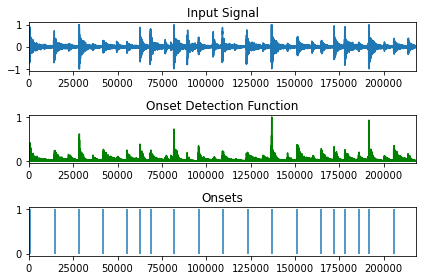

In [1411]:
fig, (sig, onset_function, onset_vector) = plt.subplots(3, 1)

sig.plot(input_sig)
sig.set_title('Input Signal')
sig.set_xlim([0, odf.size])
onset_function.plot(odf, color='green')
onset_function.set_title('Onset Detection Function')
onset_function.set_xlim([0, odf.size])
onset_vector.vlines(onsets, 0, odf.max())
onset_vector.set_title('Onsets')
onset_vector.set_xlim([0, odf.size])
fig.tight_layout()
fig.show()

In [10]:
# now lets make a click track to hear the detected onsets with the input
fs2, click = wf.read('click.wav')

C:\Users\Christian\anaconda3\lib\site-packages\ipykernel_launcher.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  


In [11]:
# resample to match the output
if fs2 != fs:
    signal.resample(click, fs)
    fs2 = fs
click[:, 0].size

8087

In [12]:
# make the input a bit quieter to better hear the click
output_sig = input_sig * 0.67

In [13]:
for o in onsets:
    output_sig[o:o+click[:, 0].size] += click[:output_sig.size-o, 0] * 0.25

In [14]:
wf.write('onset_output.wav', fs, output_sig)